In [1]:
import numpy as np
import ROOT as rt
import uproot

Welcome to JupyROOT 6.12/07


In [2]:
# Expecting 540629 qcdSigExt events
# qcdSigExt
h_t_bin_content = [201768.0, 120440.0, 73590.0, 47403.0, 30366.0, 20378.0, 13591.0, 
                   9490.0, 6295.0, 4591.0, 3336.0, 2332.0, 1740.0, 1354.0, 1004.0, 
                   710.0, 537.0, 401.0, 274.0, 243.0, 177.0, 148.0, 99.0, 77.0, 56.0, 
                   43.0, 39.0, 24.0, 22.0, 23.0]
h_a_bin_content = [1782.0, 1103.0, 786.0, 491.0, 291.0, 195.0, 120.0, 88.0, 53.0, 60.0, 
                   32.0, 24.0, 19.0, 11.0, 3.0, 4.0, 11.0, 3.0, 4.0, 6.0, 2.0, 5.0, 1.0, 
                   1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
h_r_bin_content = [199986.0, 119337.0, 72804.0, 46912.0, 30075.0, 20183.0, 13471.0, 9402.0, 
                   6242.0, 4531.0, 3304.0, 2308.0, 1721.0, 1343.0, 1001.0, 706.0, 526.0, 398.0, 
                   270.0, 237.0, 175.0, 143.0, 98.0, 76.0, 55.0, 42.0, 38.0, 24.0, 22.0, 23.0]

# xsec BSM = 1.00E+1
# Expecting 11281 GtoWW3 events
# GtoWW3
h_t_signal = [61.0, 66.0, 100.0, 126.0, 142.0, 213.0, 218.0, 294.0, 356.0, 398.0, 438.0, 438.0, 
              499.0, 548.0, 484.0, 504.0, 499.0, 524.0, 505.0, 510.0, 525.0, 629.0, 706.0, 764.0, 
              826.0, 563.0, 219.0, 49.0, 23.0, 14.0]
h_a_signal = [28.0, 35.0, 44.0, 63.0, 74.0, 109.0, 92.0, 109.0, 124.0, 128.0, 109.0, 86.0, 68.0, 
              53.0, 23.0, 24.0, 17.0, 10.0, 16.0, 9.0, 7.0, 10.0, 14.0, 15.0, 14.0, 11.0, 6.0, 2.0, 
              0.0, 0.0]
h_r_signal = [33.0, 31.0, 56.0, 63.0, 68.0, 104.0, 126.0, 185.0, 232.0, 270.0, 329.0, 352.0, 431.0, 
              495.0, 461.0, 480.0, 482.0, 514.0, 489.0, 501.0, 518.0, 619.0, 692.0, 749.0, 812.0, 
              552.0, 213.0, 47.0, 23.0, 14.0]

bin_edges = np.linspace(1100,4000,31)

n_bins = len(bin_edges)-1
max_bin = bin_edges[-1]
min_bin = bin_edges[0]

In [3]:
# prepare histograms and scale
background_hist_acc = rt.TH1D('background_acc','background_acc', n_bins, min_bin, max_bin)
signal_hist_acc = rt.TH1D('signal_acc','signal_acc', n_bins, min_bin, max_bin)
data_hist_acc = rt.TH1D('data_obs_acc','data_obs_acc', n_bins, min_bin, max_bin)

background_hist_rej = rt.TH1D('background_rej','background_rej', n_bins, min_bin, max_bin)
signal_hist_rej = rt.TH1D('signal_rej','signal_rej', n_bins, min_bin, max_bin)
data_hist_rej = rt.TH1D('data_obs_rej','data_obs_rej', n_bins, min_bin, max_bin)

for i, b in enumerate(h_a_bin_content):
    background_hist_acc.SetBinContent(i+1, b)
    data_hist_acc.SetBinContent(i+1, b)
for i, s in enumerate(h_a_signal):
    signal_hist_acc.SetBinContent(i+1, s)
    
for i, b in enumerate(h_r_bin_content):
    background_hist_rej.SetBinContent(i+1, b)
    data_hist_rej.SetBinContent(i+1, b)
for i, s in enumerate(h_r_signal):
    signal_hist_rej.SetBinContent(i+1, s)

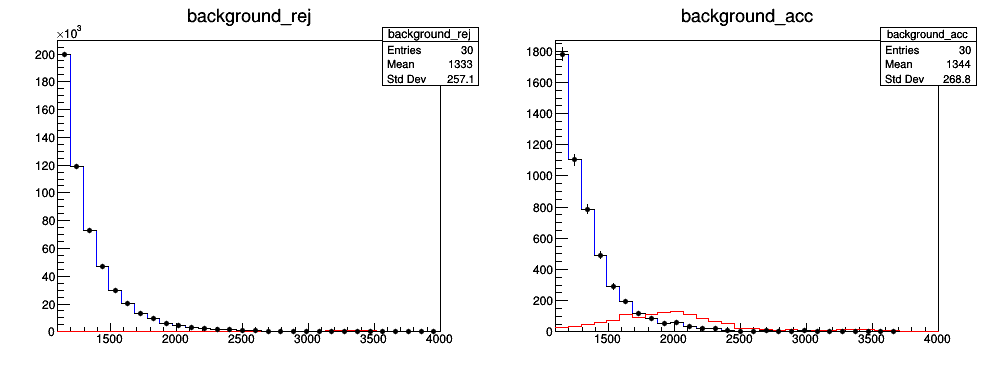

In [4]:
# plot background, signal, data
c = rt.TCanvas('c','c',1000,400)
c.Divide(2,1)

c.cd(1)
background_hist_rej.SetLineColor(rt.kBlue)
background_hist_rej.Draw('hist')
signal_hist_rej.SetLineColor(rt.kRed)
signal_hist_rej.Draw('histsame')
data_hist_rej.SetLineColor(rt.kBlack)
data_hist_rej.SetMarkerColor(rt.kBlack)
data_hist_rej.SetMarkerStyle(20)
data_hist_rej.SetMarkerSize(0.5)
data_hist_rej.Draw('pezsame')

c.cd(2)
background_hist_acc.SetLineColor(rt.kBlue)
background_hist_acc.Draw('hist')
signal_hist_acc.SetLineColor(rt.kRed)
signal_hist_acc.Draw('histsame')
data_hist_acc.SetLineColor(rt.kBlack)
data_hist_acc.SetMarkerColor(rt.kBlack)
data_hist_acc.SetMarkerStyle(20)
data_hist_acc.SetMarkerSize(0.5)
data_hist_acc.Draw('pezsame')

c.Draw()

In [ ]:
# set up workspace

datacard_ws = rt.TFile.Open('datacard_ws.root','recreate')
w = rt.RooWorkspace('w','w')
x = rt.RooRealVar('x','x',min_bin,max_bin)
w.factory('x[%.1f,%.1f]'%(min_bin, max_bin))

acc_bin_functions = rt.RooArgList()
rej_bin_functions = rt.RooArgList()
w.factory('eff[%f,0,1]'%(background_hist_acc.Integral()/background_hist_rej.Integral()))
w.var('eff').setConstant(True)

empty_hist = rt.TH1D('empty_hist','empty_hist', n_bins, min_bin, max_bin)
for iBinX in range(1,n_bins+1):
    empty_hist.SetBinContent(iBinX,1)
    w.factory('crBin%i_In[%.1f]'%(iBinX,background_hist_rej.GetBinContent(iBinX)))
    w.factory('crBin%i[0,-100,100]'%(iBinX))
    w.var('crBin%i_In'%iBinX).setConstant(True)
    w.var('crBin%i'%iBinX).setConstant(False)
    w.factory("expr::crBin%iFunc('max(0,@0*pow(1.0+%f,@1))',crBin%i_In,crBin%i)"%(iBinX,1/rt.TMath.Sqrt(background_hist_rej.GetBinContent(iBinX)),iBinX,iBinX))
    w.factory("expr::bin%iFunc('max(0,@0*@1)',eff,crBin%iFunc)"%(iBinX,iBinX))
    rej_bin_functions.add(w.function('crBin%iFunc'%iBinX))
    acc_bin_functions.add(w.function('bin%iFunc'%iBinX))
    
qcd_rph_rej = rt.RooParametricHist('background_rej','background_acc',w.var('x'),rej_bin_functions,empty_hist)
qcd_rph_rej_norm = rt.RooAddition('background_rej_norm','background_rej_norm',rej_bin_functions)
qcd_rph_acc = rt.RooParametricHist('background_acc','background_acc',w.var('x'),acc_bin_functions,empty_hist)
qcd_rph_acc_norm = rt.RooAddition('background_acc_norm','background_acc_norm',acc_bin_functions)
getattr(w,'import')(qcd_rph_rej, rt.RooCmdArg())
getattr(w,'import')(qcd_rph_rej_norm, rt.RooFit.RecycleConflictNodes())
getattr(w,'import')(qcd_rph_acc, rt.RooCmdArg())
getattr(w,'import')(qcd_rph_acc_norm, rt.RooFit.RecycleConflictNodes())

ds_signal_acc = rt.RooDataHist('signal_acc','signal_acc',rt.RooArgList(w.var('x')),signal_hist_acc)
ds_signal_rej = rt.RooDataHist('signal_rej','signal_rej',rt.RooArgList(w.var('x')),signal_hist_rej)
getattr(w,'import')(ds_signal_acc, rt.RooCmdArg())
getattr(w,'import')(ds_signal_rej, rt.RooCmdArg())

ds_data_acc = rt.RooDataHist('data_obs_acc','data_obs_acc',rt.RooArgList(w.var('x')),data_hist_acc)
ds_data_rej = rt.RooDataHist('data_obs_rej','data_obs_rej',rt.RooArgList(w.var('x')),data_hist_rej)
getattr(w,'import')(ds_data_acc, rt.RooCmdArg())
getattr(w,'import')(ds_data_rej, rt.RooCmdArg())

datacard_ws.cd()
w.Write()
datacard_ws.Close()

w.Print('v')

In [6]:
# datacard template
# no background normalization uncertainty

datacard_ratio = \
'''
imax 1
jmax 1
kmax *
---------------
shapes * * datacard_ws.root w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin {BIN}
observation {OBS}
------------------------------
bin             {BIN}      {BIN}
process         signal     background
process         0          1
rate            {SIGRATE}    {BKGRATE}
--------------------------------
lumi lnN 1.01 -
eff   flatParam
crBin1   flatParam
crBin2   flatParam
crBin3   flatParam
crBin4   flatParam
crBin5   flatParam
crBin6   flatParam
crBin7   flatParam
crBin8   flatParam
crBin9   flatParam
crBin10   flatParam
crBin11   flatParam
crBin12   flatParam
crBin13   flatParam
crBin14   flatParam
crBin15   flatParam
crBin16   flatParam
crBin17   flatParam
crBin18   flatParam
crBin19   flatParam
crBin20   flatParam
crBin21   flatParam
crBin22   flatParam
crBin23   flatParam
crBin24   flatParam
crBin25   flatParam
crBin26   flatParam
crBin27   flatParam
crBin28   flatParam
crBin29   flatParam
crBin30   flatParam
'''

In [7]:
# write datacard
datacard_ratio_acc = datacard_ratio.format(BIN='acc',
                          OBS=data_hist_acc.Integral(),
                          BKGRATE=1,
                          SIGRATE=signal_hist_acc.Integral())
print(datacard_ratio_acc)
with open('datacard_ratio_acc.txt','w') as f:
    f.write(datacard_ratio_acc)
    
    
datacard_ratio_rej = datacard_ratio.format(BIN='rej',
                          OBS=data_hist_rej.Integral(),
                          BKGRATE=1,
                          SIGRATE=signal_hist_rej.Integral())
print(datacard_ratio_rej)
with open('datacard_ratio_rej.txt','w') as f:
    f.write(datacard_ratio_rej)


imax 1
jmax 1
kmax *
---------------
shapes * * datacard_ws.root w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin acc
observation 5098.0
------------------------------
bin             acc      acc
process         signal     background
process         0          1
rate            1300.0    1
--------------------------------
lumi lnN 1.01 -
eff   flatParam
crBin1   flatParam
crBin2   flatParam
crBin3   flatParam
crBin4   flatParam
crBin5   flatParam
crBin6   flatParam
crBin7   flatParam
crBin8   flatParam
crBin9   flatParam
crBin10   flatParam
crBin11   flatParam
crBin12   flatParam
crBin13   flatParam
crBin14   flatParam
crBin15   flatParam
crBin16   flatParam
crBin17   flatParam
crBin18   flatParam
crBin19   flatParam
crBin20   flatParam
crBin21   flatParam
crBin22   flatParam
crBin23   flatParam
crBin24   flatParam
crBin25   flatParam
crBin26   flatParam
crBin27   flatParam
crBin28   flatParam
crBin29   flatParam
crBin30   flatParam


imax 1
jmax 1
kmax *
-----

In [ ]:
!combineCards.py rej=datacard_ratio_rej.txt acc=datacard_ratio_acc.txt > datacard_ratio.txt

# get obseverved goodness of fit test statistic (signal strength = 0)
!combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard_ratio.txt

# get expected goodness of fit test statistic distribution from frequentist toys
!combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard_ratio.txt -t 100 --toysFreq

In [9]:
# open file
obs_gof_file = uproot.open('higgsCombineTest.GoodnessOfFit.mH120.root')
obs_gof = obs_gof_file['limit'].arrays('limit')['limit'][0]

exp_gof_file = uproot.open('higgsCombineTest.GoodnessOfFit.mH120.123456.root')
exp_gof = exp_gof_file['limit'].arrays('limit')['limit']

# # get p-value
n_extreme = len(exp_gof[exp_gof > obs_gof])
n_total = len(exp_gof)
pval = 1.*n_extreme/n_total
print 'p-value = %.2f'%pval

p-value = 0.01


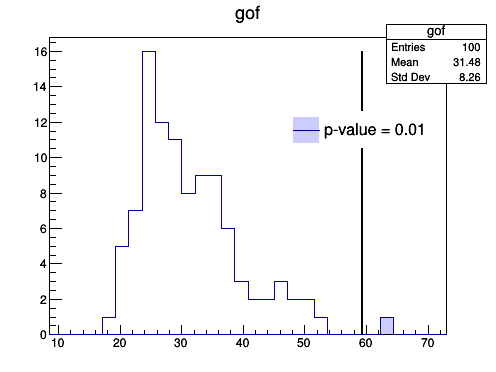

In [10]:
exp_gof_hist = rt.TH1D('gof','gof',30,min(exp_gof)-10, max(exp_gof)+10)
exp_gof_hist_gt = rt.TH1D('gof_gt','gof_gt',30,min(exp_gof)-10, max(exp_gof)+10)
for g in exp_gof: 
    exp_gof_hist.Fill(g)
    if g > obs_gof: 
        exp_gof_hist_gt.Fill(g)
d = rt.TCanvas('d','d',500,400)
tleg = rt.TLegend(0.58,0.6,0.88,0.7)
tleg.SetLineWidth(0)
exp_gof_hist.Draw('hist')
exp_gof_hist_gt.SetFillColor(rt.kBlue-10)
exp_gof_hist_gt.Draw('fhistsame')
line = rt.TLine(obs_gof,0,obs_gof,exp_gof_hist.GetMaximum())
line.SetLineWidth(2)
line.Draw()
tleg.AddEntry(exp_gof_hist_gt,'p-value = %.2f'%pval)
tleg.Draw()
d.Draw()

In [ ]:
# get significance for a range of signal cross sections
import os

orig_xsec = 10.
xsec_to_scan = np.logspace(-4,0,10)

for mu in xsec_to_scan/orig_xsec:    
    os.environ['MU'] = str(mu)
    !combine -M Significance --setParameters r=${MU} -d datacard_ratio.txt -t -1 -n mu_${MU}

In [12]:
# open file
for mu in xsec_to_scan/orig_xsec:    
    xsec = mu*orig_xsec
    signif_file = uproot.open('higgsCombinemu_%s.Significance.mH120.root'%str(mu))
    signif = signif_file['limit'].arrays('limit')['limit'][0]
    pval = rt.RooStats.SignificanceToPValue(signif)
    
    print('xsec', xsec, 'mu', mu, 'pval', pval, 'signif', signif)

('xsec', 0.0001, 'mu', 1e-05, 'pval', 0.5, 'signif', 0.0)
('xsec', 0.0002782559402207126, 'mu', 2.7825594022071256e-05, 'pval', 0.5, 'signif', 0.0)
('xsec', 0.000774263682681127, 'mu', 7.74263682681127e-05, 'pval', 0.5, 'signif', 0.0)
('xsec', 0.002154434690031882, 'mu', 0.0002154434690031882, 'pval', 0.49650983725510334, 'signif', 0.008748652220199582)
('xsec', 0.005994842503189409, 'mu', 0.0005994842503189409, 'pval', 0.48868605676915694, 'signif', 0.028363652619024182)
('xsec', 0.016681005372000592, 'mu', 0.0016681005372000592, 'pval', 0.4668083592913855, 'signif', 0.08329532362318469)
('xsec', 0.046415888336127774, 'mu', 0.004641588833612777, 'pval', 0.4083512056567598, 'signif', 0.23178834318751462)
('xsec', 0.12915496650148828, 'mu', 0.012915496650148827, 'pval', 0.26149654340481976, 'signif', 0.6387384625155118)
('xsec', 0.3593813663804626, 'mu', 0.03593813663804626, 'pval', 0.04144765215349881, 'signif', 1.7341283952814823)
('xsec', 1.0, 'mu', 0.1, 'pval', 2.1808004816063374e-0

In [ ]:
# check just regular fit
!combine -M FitDiagnostics -d datacard_ratio.txt --plots -v 2

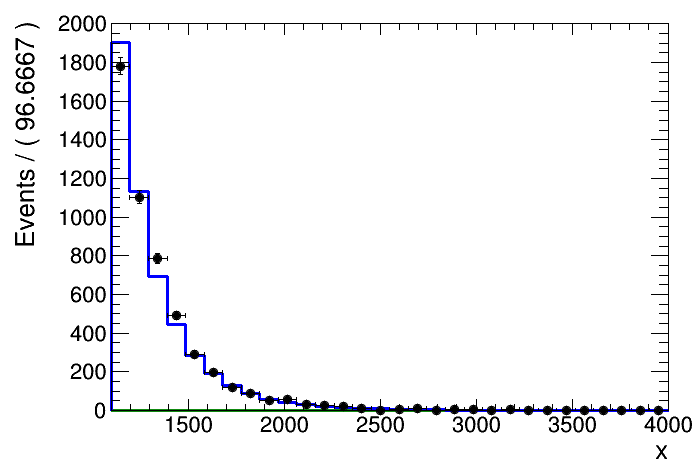

In [14]:
# accept region doesn't look great
from IPython.display import Image
Image(filename='acc_x_fit_b.png') 